In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook', palette = 'deep')

In [2]:
train = pd.read_csv('C:/Users/user/titanic/train.csv')
test = pd.read_csv('C:/Users/user/titanic/test.csv')
IDtest = test['PassengerId']

In [3]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the Tukey method.
    """
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col]< Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
        
    return multiple_outliers
Outliers_to_drop = detect_outliers(train, 2, ['Age', 'SibSp', 'Parch', 'Fare'])

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)

In [6]:
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

In [7]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


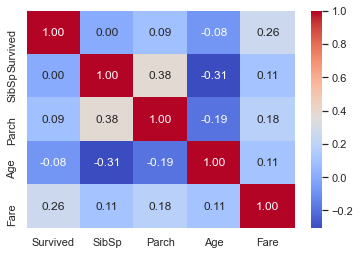

In [12]:
g = sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')

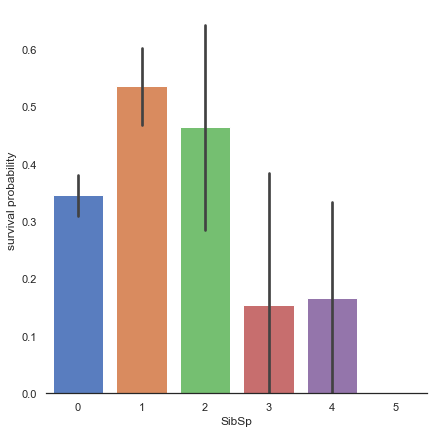

In [13]:
g = sns.factorplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

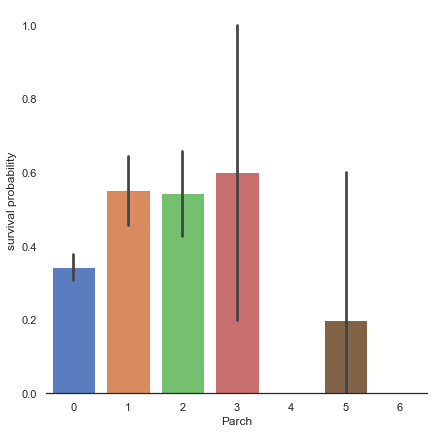

In [14]:
g = sns.factorplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

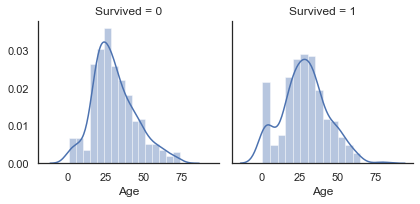

In [15]:
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

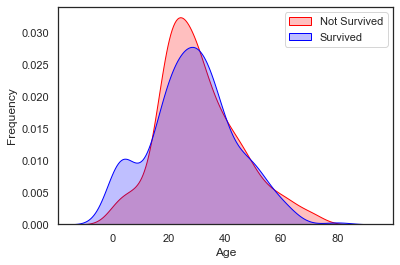

In [16]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax = g, color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

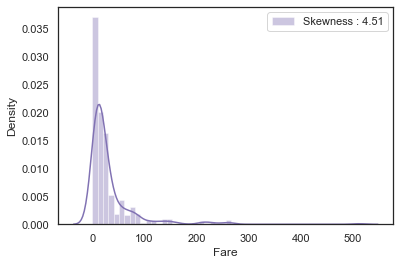

In [19]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

In [20]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

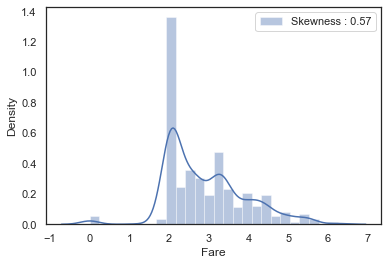

In [21]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

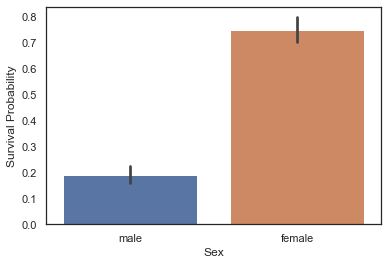

In [22]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


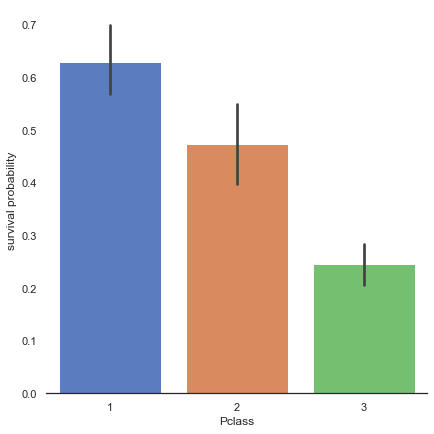

In [24]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

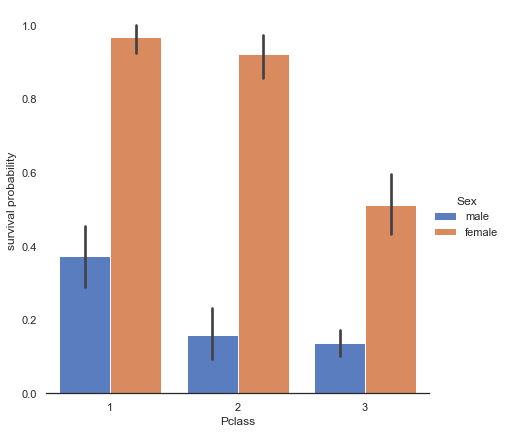

In [25]:
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

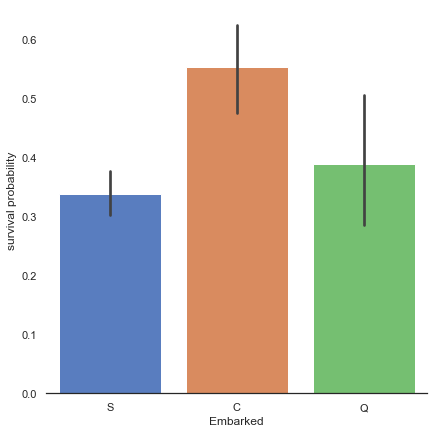

In [28]:
g = sns.factorplot(x = 'Embarked', y = 'Survived', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

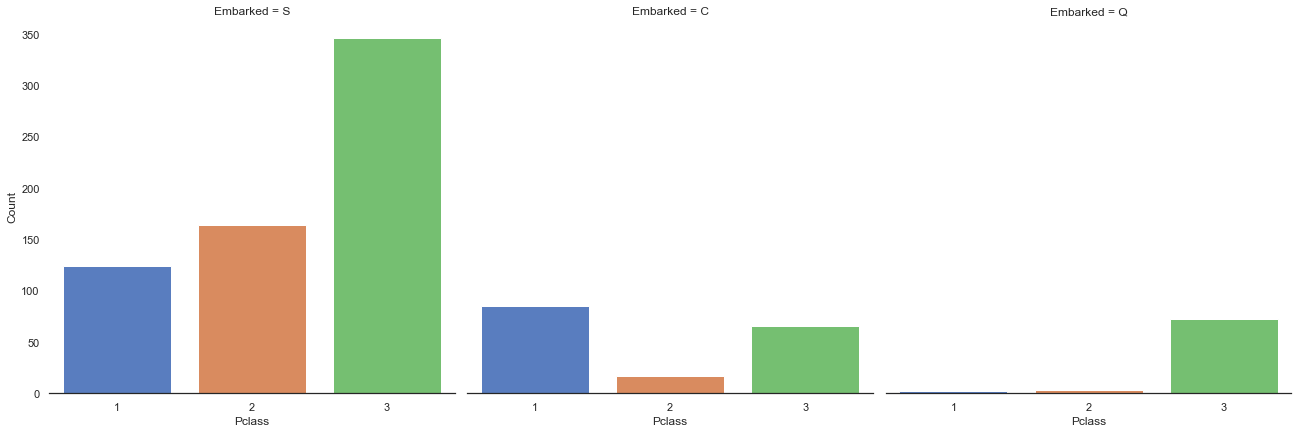

In [29]:
g = sns.factorplot('Pclass', col = 'Embarked', data = train, size = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

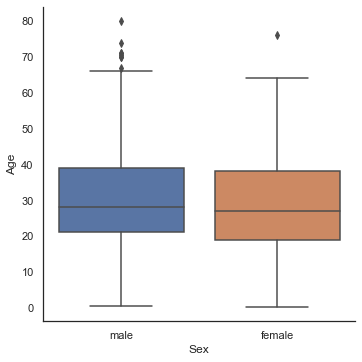

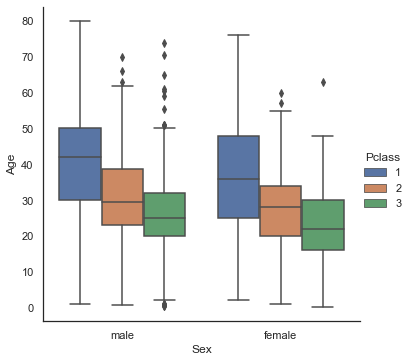

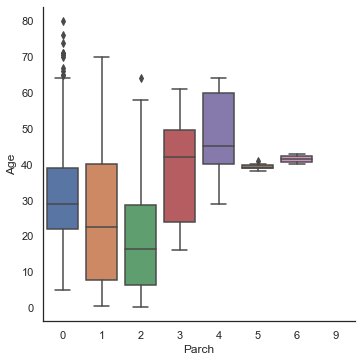

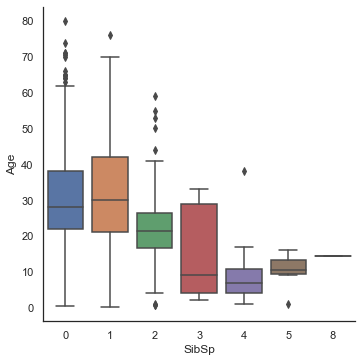

In [30]:
g = sns.factorplot(y = 'Age', x = 'Sex', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Parch', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'SibSp', data = dataset, kind = 'box')

In [31]:
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female': 1})

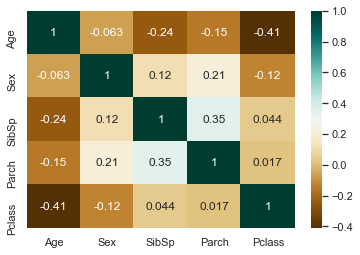

In [32]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

In [33]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age :
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) : 
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

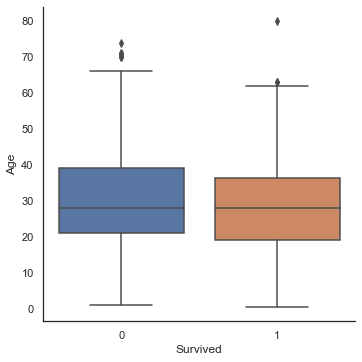

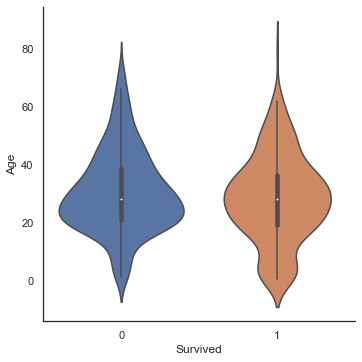

In [34]:
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

In [35]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [36]:
dataset_title = [i. split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

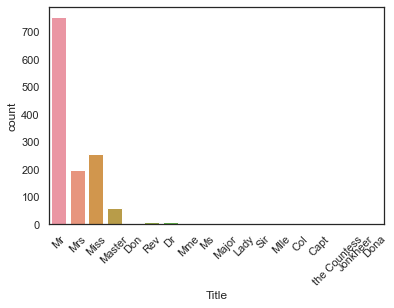

In [37]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

In [38]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master': 0, 'Miss': 1, 'Ms': 1, 'Mme': 1, 'Mlle': 1, 'Mrs': 1, 'Mr': 2, 'Rare': 3})
dataset['Title'] = dataset['Title'].astype(int)

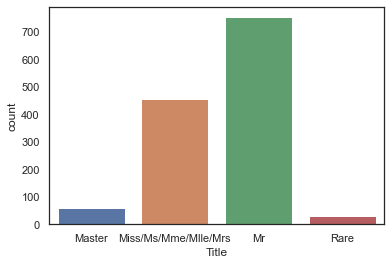

In [39]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master', 'Miss/Ms/Mme/Mlle/Mrs', 'Mr', 'Rare'])

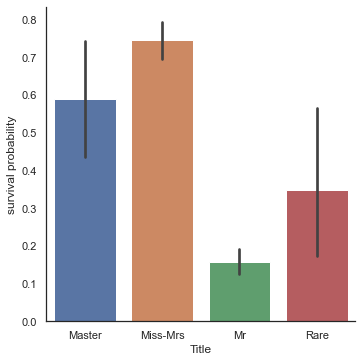

In [40]:
g = sns.factorplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs','Mr', 'Rare'])
g = g.set_ylabels('survival probability')

In [41]:
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

In [42]:
dataset['Fsize'] = dataset['SibSp']+ dataset['Parch'] + 1

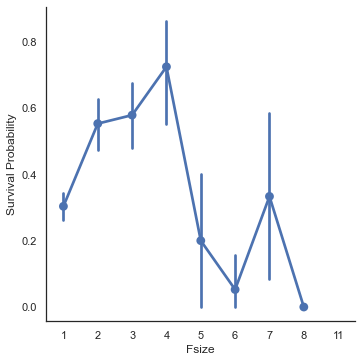

In [43]:
g = sns.factorplot(x = 'Fsize', y = 'Survived', data = dataset)
g = g.set_ylabels('Survival Probability')

In [44]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s == 2 else  0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

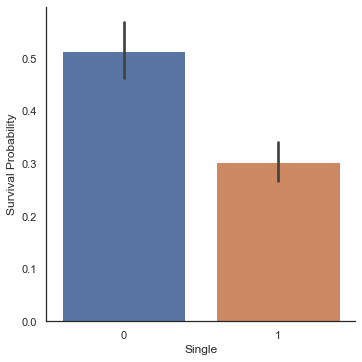

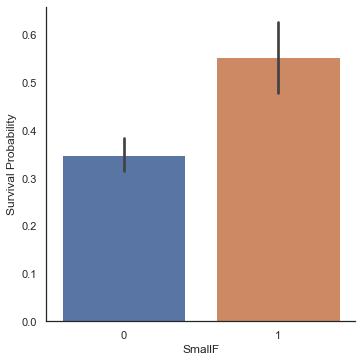

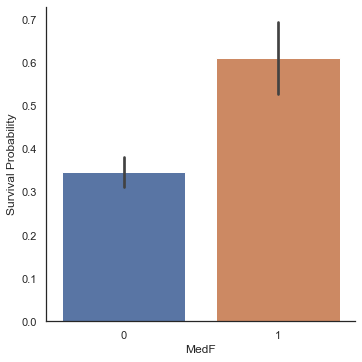

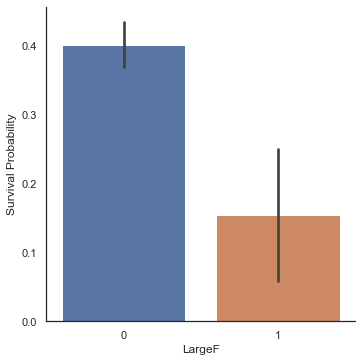

In [45]:
g = sns.factorplot(x = 'Single', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'MedF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'LargeF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

In [46]:
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em')

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [48]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].isnull().sum()

1007

In [51]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

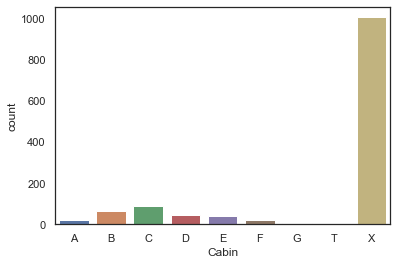

In [53]:
g = sns.countplot(dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

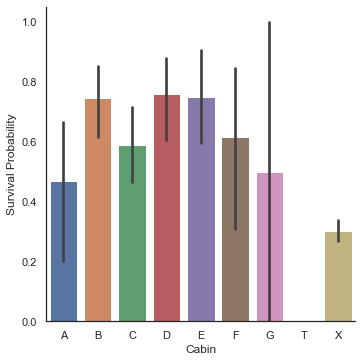

In [54]:
g = sns.factorplot(y = 'Survived', x = 'Cabin', data = dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

In [55]:
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix = 'Cabin')

In [56]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [57]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.', '').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [59]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [60]:
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [61]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [62]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

In [63]:
train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis = 1)

In [64]:
kfold = StratifiedKFold(n_splits = 10)

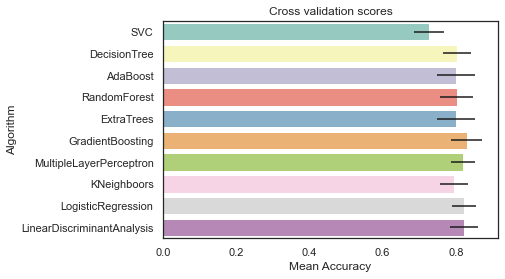

In [65]:
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs = 4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot('CrossValMeans', 'Algorithm', data = cv_res, palette = 'Set3', orient = 'h', **{'xerr': cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

In [67]:
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {'base_estimator__criterion' : ['gini', 'entropy'],
                  'base_estimator__splitter' : ['best', 'random'],
                  'algorithm' : ['SAMME', 'SAMME.R'],
                  'n_estimators' : [1, 2],
                  'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [68]:
gsadaDTC.best_score_

0.8241317671092953

In [70]:
ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth' : [None],
                'max_features' : [1, 3, 10],
                'min_samples_split' : [2, 3, 10],
                'min_samples_leaf' : [1, 3, 10],
                'bootstrap' : [False],
                'n_estimators' : [100, 300],
                'criterion' : ['gini']}

gsExtC = GridSearchCV(ExtC, param_grid = ex_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsExtC.fit(X_train, Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8320097037793668

In [71]:
RFC = RandomForestClassifier()

rf_param_grid = {'max_depth' :  [None],
                'max_features' : [1, 3, 10],
                'min_samples_split' : [2, 3, 10],
                'min_samples_leaf' : [1, 3, 10],
                'bootstrap' : [False],
                'n_estimators' : [100, 300],
                'criterion' : ['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342824310520941

In [72]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ['deviance'],
                'n_estimators' : [100, 200, 300],
                'learning_rate' : [0.1, 0.05, 0.01],
                'max_depth' : [4, 8],
                'min_samples_leaf' : [100, 150],
                'max_features' : [0.3, 0.1]}

gsGBC = GridSearchCV(GBC, param_grid = gb_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsGBC.fit(X_train, Y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8331460674157304

In [73]:
SVMC = SVC(probability = True)
svc_param_grid = {'kernel' : ['rbf'],
                 'gamma' : [0.001, 0.01, 0.1, 1],
                 'C' : [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, param_grid = svc_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsSVMC.fit(X_train, Y_train)

SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim = None, cv = None, n_jobs = -1, train_sizes = np.linespace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = n_jobs, train_sizes = train_sizes)
    train_scores_mean = np.mean(train_scores, axis = 1)
    train_scores_std = np.std(train_scores, axis = 1)
    test_scores_mean = np.mean(test_scores, axis = 1)
    test_scores_std = np.std(test_scores, axis = 1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean)